In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import os
import re
import numpy as np
from tqdm import tqdm
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
MAX_WORD = 10000  # 只保留最高频的10000词
MAX_LEN = 300     # 句子统一长度为300
word_count={}     # 词-词出现的词数 词典

In [3]:
#清理文本，去标点符号，转小写
def clean_str(string):
    string = re.sub(r"[^A-Za-z0-9]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"sssss ", " ", string)
    return string.strip().lower()
    
# 分词方法
def tokenizer(sentence):
    return sentence.split()

#  数据预处理过程
def data_process(text_path, text_dir): # 根据文本路径生成文本的标签

    print("data preprocess")
    file_pro = open(text_path,'w',encoding='utf-8')
    for root, s_dirs, _ in os.walk(text_dir): # 获取 train文件下各文件夹名称
        for sub_dir in s_dirs:
            i_dir = os.path.join(root, sub_dir)  # 获取train和test文件夹下所有的路径
            text_list = os.listdir(i_dir)
            tag = os.path.split(i_dir)[-1] # 获取标签
            if tag == 'pos':
                label = '1'
            if tag == 'neg':
                label = '0'
            if tag =='unsup':
                continue

            for i in range(len(text_list)):
                if not text_list[i].endswith('txt'): # 判断若不是txt,则跳过
                    continue
                f = open(os.path.join(i_dir, text_list[i]),'r',encoding='utf-8') # 打开文本
                raw_line = f.readline()
                pro_line = clean_str(raw_line)
                tokens = tokenizer(pro_line) # 分词统计词数
                for token in tokens:
                    if token in word_count.keys():
                        word_count[token] = word_count[token] + 1
                    else:
                        word_count[token] = 0
                file_pro.write(label + ' ' + pro_line +'\n')
                f.close()
                file_pro.flush()
    file_pro.close()

    print("build vocabulary")

    vocab = {"<UNK>": 0, "<PAD>": 1}

    word_count_sort = sorted(word_count.items(), key=lambda item : item[1], reverse=True) # 对词进行排序，过滤低频词，只取前MAX_WORD个高频词
    word_number = 1
    for word in word_count_sort:
        if word[0] not in vocab.keys():
            vocab[word[0]] = len(vocab)
            word_number += 1
        if word_number > MAX_WORD:
            break
    return vocab

In [5]:
train_dir = './data/aclImdb/train'  # 原训练集文件地址
train_path = './train.txt'  # 预处理后的训练集文件地址

test_dir = './data/aclImdb/test'  # 原训练集文件地址
test_path = './test.txt'  # 预处理后的训练集文件地址

vocab = np.load('vocab.npy', allow_pickle=True).item()  # 加载本地已经存储的vocab

In [7]:
# 定义Dataset
class MyDataset(Dataset):
    def __init__(self, text_path):
        file = open(text_path, 'r', encoding='utf-8')
        self.text_with_tag = file.readlines()  # 文本标签与内容
        file.close()

    def __getitem__(self, index): # 重写getitem
        line = self.text_with_tag[index] # 获取一个样本的标签和文本信息
        label = int(line[0]) # 标签信息
        text = line[2:-1]  # 文本信息
        return text, label

    def __len__(self):
        return len(self.text_with_tag)

In [20]:
# 定义GRU模型
class GRU(nn.Module):
    def __init__(self, vocab, embed_size, num_hiddens, num_layers):
        super(GRU, self).__init__()
        self.embedding = nn.Embedding(len(vocab), embed_size) # embedding层

        self.encoder = nn.GRU(input_size=embed_size,
                               hidden_size=num_hiddens,
                               num_layers=num_layers,
                               bidirectional=False)
        self.decoder = nn.Linear(num_hiddens, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, inputs):
        embeddings = self.embedding(inputs.permute(1,0))
        outputs, _ = self.encoder(embeddings)
        encoding = outputs[-1]
        outs = self.softmax(self.decoder(encoding))
        return outs

In [21]:
# 构建MyDataset实例
train_data = MyDataset(text_path=train_path)
test_data = MyDataset(text_path=test_path)

# 构建DataLoder
train_loader = DataLoader(dataset=train_data, batch_size=256, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=64, shuffle=False)

In [22]:
def train(model, train_data, vocab, epoch=10):
    model = model.to(device)
    loss_sigma = 0.0
    correct = 0.0
    # 定义损失函数和优化器
    criterion = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
    
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []
    accs_0 = []
    accs_1 = []

    for epoch in range(epoch):
        print('train model')
        model.train()
        avg_loss = 0  # 平均损失
        avg_acc = 0  # 平均准确率
        for idx, (text, label) in enumerate(train_data):

            train_x = text_transform(text, vocab).to(device)
            train_y = label.to(device)

            optimizer.zero_grad()
            pred = model(train_x)
            loss = criterion(pred.log(), train_y)
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            avg_acc += accuracy(pred, train_y)
        # 一个epoch结束后，计算平均loss和评平均acc
        avg_loss = avg_loss / len(train_data)
        avg_acc = avg_acc / len(train_data)
        avg_acc = avg_acc*100.

        print("avg_loss:", avg_loss, " train_avg_acc:", avg_acc)
        test_loss,test_acc,acc_0,acc_1 = test(model=model, test_data=test_loader, vocab=vocab)
        print("test loss:",test_loss,"total accuracy:",test_acc,"neg accuracy:",acc_0,"pos accuracy:",acc_1)
        
        train_losses.append(avg_loss)
        train_accs.append(avg_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        accs_0.append(acc_0)
        accs_1.append(acc_1)

    # 保存训练完成后的模型参数
    torch.save(model.state_dict(), 'GRU_IMDB_parameter.pkl')
    return train_losses,train_accs,test_losses,test_accs,accs_0,accs_1

# 根据vocab将句子转为定长MAX_LEN的tensor
def text_transform(sentence_list, vocab):
    sentence_index_list = []
    for sentence in sentence_list:
        sentence_idx = [vocab[token] if token in vocab.keys() else vocab['<UNK>'] for token in tokenizer(sentence)] # 句子分词转为id

        if len(sentence_idx) < MAX_LEN:
            for i in range(MAX_LEN-len(sentence_idx)): # 对长度不够的句子进行PAD填充
                sentence_idx.append(vocab['<PAD>'])

        sentence_idx = sentence_idx[:MAX_LEN] # 取前MAX_LEN长度
        sentence_index_list.append(sentence_idx)
    return torch.LongTensor(sentence_index_list) # 将转为idx的词转为tensor
# 模型测试
def test(model, test_data, vocab):
    print('test model')
    model = model.to(device)
    model.eval()
    
    sum_0=0
    sum_1=0
    correct_0=0
    correct_1=0
    total = 0
    correct =0
    
    criterion = torch.nn.NLLLoss()
    running_loss = 0.0
    
    for idx, (text, label) in enumerate(test_data):
        test_x = text_transform(text, vocab).to(device)
        test_y = label.to(device)
        pred = model(test_x)
        
        loss = criterion(pred.log(), test_y)        
        running_loss += loss.item()
        
        _, predicted = pred.max(1)
        total += test_y.size(0)
        correct += predicted.eq(test_y).sum().item()
        
        label_pred = pred.max(dim=1)[1]
        for i in range(len(test_y)):
            if(test_y[i] == 0):
                sum_0 += 1
                if(label_pred[i] == 0):
                    correct_0 += 1
            elif(test_y[i] == 1):
                sum_1 += 1
                if(label_pred[i] == 1):
                    correct_1 += 1       
        correct=correct_0+correct_1

    test_loss = running_loss / len(test_data)
    test_acc = 100.*correct/total
    acc_0 = 100. * correct_0 / sum_0
    acc_1 = 100. * correct_1 / sum_1
    return test_loss,test_acc,acc_0,acc_1

# 计算预测准确性
def accuracy(y_pred, y_true):
    label_pred = y_pred.max(dim=1)[1]
    acc = len(y_pred) - torch.sum(torch.abs(label_pred-y_true)) # 正确的个数
    return acc.detach().cpu().numpy() / len(y_pred)

In [27]:
model = GRU(vocab=vocab, embed_size=300, num_hiddens=128, num_layers=2)  # 定义模型

train_losses,train_accs,test_losses,test_accs,accs_0,accs_1=train(model=model, train_data=train_loader, vocab=vocab, epoch=20)

train model
avg_loss: 0.6304717750488957  train_avg_acc: 65.72340144986086
test model
test loss: 0.4237343585475936 total accuracy: 80.848 neg accuracy: 76.888 pos accuracy: 84.808
train model
avg_loss: 0.28865367607979836  train_avg_acc: 87.99148122587306
test model
test loss: 0.3086423299006184 total accuracy: 86.704 neg accuracy: 92.248 pos accuracy: 81.16
train model
avg_loss: 0.13195246326017984  train_avg_acc: 95.43976260211868
test model
test loss: 0.354163971365146 total accuracy: 85.96 neg accuracy: 92.288 pos accuracy: 79.632
train model
avg_loss: 0.0507617226648557  train_avg_acc: 98.39170089325793
test model
test loss: 0.516534931028781 total accuracy: 85.732 neg accuracy: 91.08 pos accuracy: 80.384
train model
avg_loss: 0.0406767137442963  train_avg_acc: 98.63398728566298
test model
test loss: 0.5162296011059038 total accuracy: 85.996 neg accuracy: 90.28 pos accuracy: 81.712
train model
avg_loss: 0.023135455198515252  train_avg_acc: 99.24035202890744
test model
test loss: 

In [28]:
import pandas as pd
result=pd.DataFrame()
result['train_losses']=train_losses
result['train_accs']=train_accs
result['test_losses']=test_losses
result['test_accs']=test_accs
result['accs_0']=accs_0
result['accs_1']=accs_1

In [29]:
result

,train_losses,train_accs,test_losses,test_accs,accs_0,accs_1
0,0.630472,65.723401,0.423734,80.848,76.888,84.808
1,0.288654,87.991481,0.308642,86.704,92.248,81.160
2,0.131952,95.439763,0.354164,85.960,92.288,79.632
3,0.050762,98.391701,0.516535,85.732,91.080,80.384
4,0.040677,98.633987,0.516230,85.996,90.280,81.712
5,0.023135,99.240352,0.552709,85.988,88.784,83.192
6,0.014096,99.585564,0.670479,85.616,89.224,82.008
7,0.015087,99.531173,0.774278,83.500,92.816,74.184
8,0.026250,99.150437,0.661213,84.540,91.872,77.208
9,0.015609,99.510483,0.672227,84.816,91.536,78.096


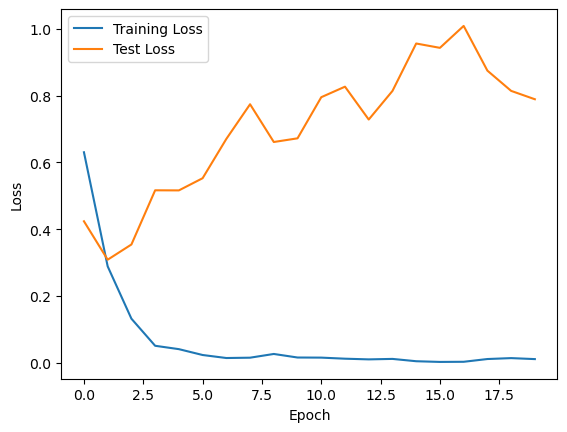

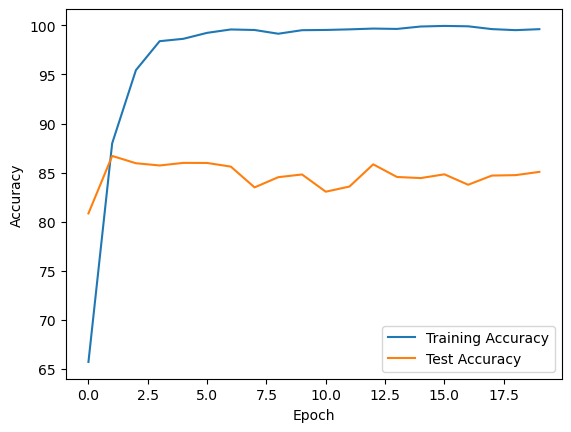

In [30]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.pyplot as plt
plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(train_accs, label='Training Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()